In [3]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
#import healpy as hp
from lightkurve import search_lightcurve
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from fleck import Star
from schwimmbad import MultiPool

Next we resolve the target coordinates using astropy, and download its light curve using lightkurve’s handy method:

In [26]:
coord = SkyCoord.from_name('V1298 Tau')
slcf = search_lightcurve(coord, mission='TESS')

lc = slcf.download_all()
pdcsap = lc.stitch()

time = pdcsap.time.jd
flux = pdcsap.flux

notnanflux = ~np.isnan(flux)

flux = flux[notnanflux]
time = time[notnanflux]

flux /= np.mean(flux)

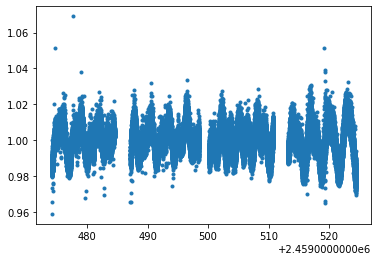

In [27]:
plt.plot(time,flux,".")

Next, we want to determine the stellar rotation period, which will remain fixed in our fleck analysis. We do this with a Lomb-Scargle periodogram:

In [5]:
periods = np.linspace(1, 5, 1000) * u.day
freqs = 1 / periods
powers = LombScargle(time * u.d, flux).power(freqs)
best_period = periods[powers.argmax()]
print(best_period)

2.961961961961962 d


Now that we know that the best period is roughly 2.87 days, we can generate fleck light curves that reproduce the spot modulation:

In [6]:
u_ld = [0.46, 0.11]
contrast = 0.7
phases = (time % best_period.value) / best_period.value
s = Star(contrast, u_ld, n_phases=len(time), rotation_period=best_period.value)

init_lons = np.array([0, 320, 100])
init_lats = [0, 20, 0]
init_rads = [0.01, 0.2, 0.3]

yerr = 0.002

init_p = np.concatenate([init_lons, init_lats, init_rads])

With our initial parameters set, we now define the functions that emcee uses to do Markov Chain Monte Carlo:

In [26]:
def log_likelihood(p):
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]

    lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None],
                       inc_stellar=90*u.deg, times=time, time_ref=0)[:, 0]

    ret = - 0.5 * np.sum((lc/np.mean(lc) - flux)**2 / yerr**2)
    return ret.value

def log_prior(p):
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]

    if (np.all(rads < 1.) and np.all(rads > 0) and np.all(lats > -60) and
        np.all(lats < 60) and np.all(lons > 0) and np.all(lons < 360)):
        return 0
    return -np.inf

def log_probability(p):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p)

We’ll run the chains for a short period of time to see the results faster, but to ensure convergence, you should run for 10-100x longer than this example:

In [3]:
from multiprocessing import Pool
from schwimmbad import MPIPool

In [37]:
ndim = len(init_p)
nwalkers = 5 * ndim
nsteps = 10

pos = []


while len(pos) < nwalkers:
    trial = init_p + 0.01 * np.random.randn(ndim)
    lp = log_prior(trial)
    if np.isfinite(lp):
        pos.append(trial)

if __name__ == '__main__':
    sampler = EnsembleSampler(nwalkers, ndim, log_probability,threads=10)
    sampler.run_mcmc(pos, nsteps, progress=True)

    samples_burned_in = sampler.flatchain[len(sampler.flatchain)//2:, :]

100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


In [ ]:
np.save("Samples",samples_burned_in)

Now let’s plot the corner plot with the posterior distributions and their correlations using the corner package:

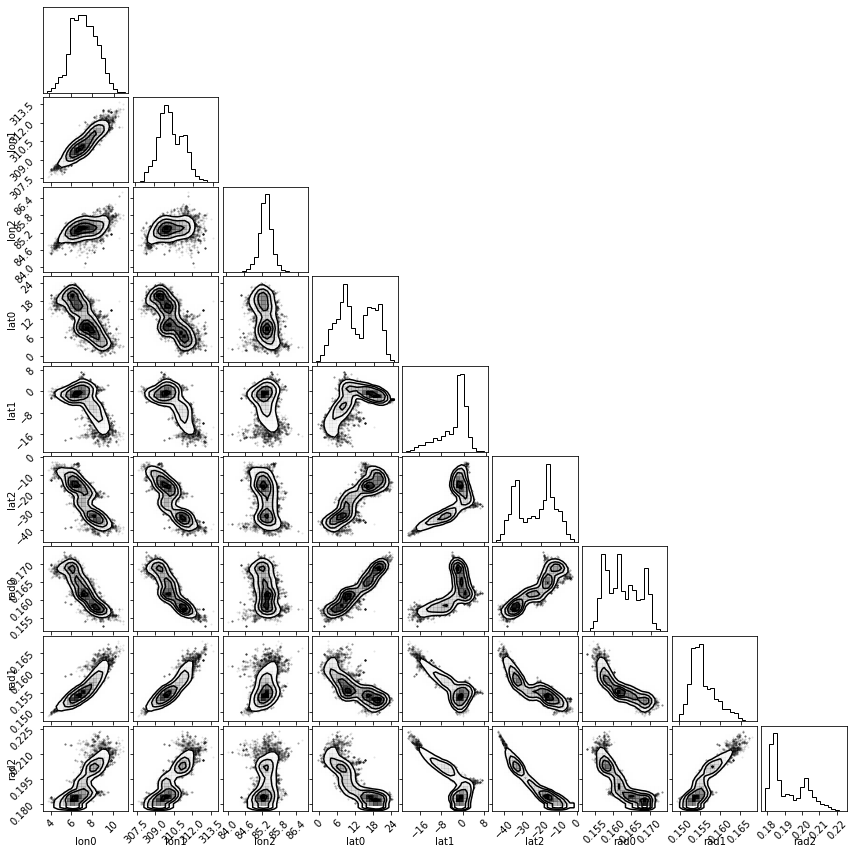

In [ ]:
fig, ax = plt.subplots(9, 9, figsize=(12, 12))
labels = "lon0 lon1 lon2 lat0 lat1 lat2 rad0 rad1 rad2".split()
corner(samples_burned_in, smooth=True, labels=labels,
       fig=fig);
plt.show()

Finally, let’s plot several draws from the posterior distributions for near the maximum-likelihood light curve model, the total spot coverage posterior distribution, and the spot map using healpy:

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys").copy()
0.0 180.0 -180.0 180.0


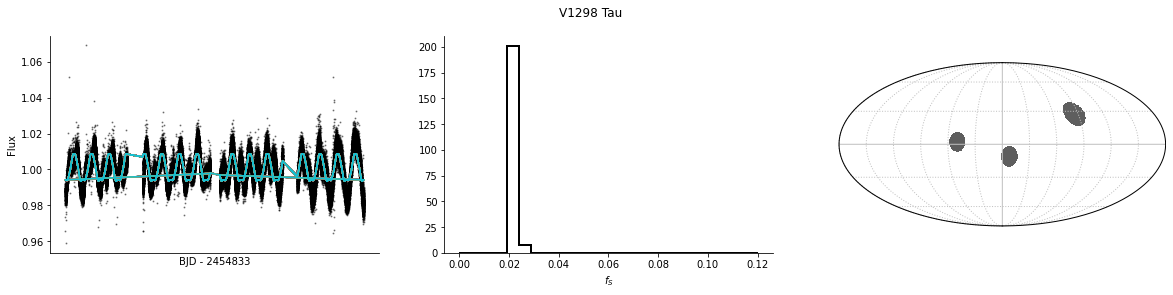

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i in np.random.randint(0, len(samples_burned_in), size=50):

    trial = samples_burned_in[i, :]

    lons = trial[0:3]
    lats = trial[3:6]
    rads = trial[6:9]

    lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None],
                       inc_stellar=90*u.deg, times=time, time_ref=0)[:, 0]
    ax[0].plot(time, lc/lc.mean(),"-",zorder=1)

f_S = np.sum(samples_burned_in[:, -3:]**2 / 4, axis=1)

ax[1].hist(f_S, bins=25, histtype='step', lw=2, color='k', range=[0, 0.12], density=True)
ax[0].set(xlabel='BJD - 2454833', ylabel='Flux', xticks=[2230, 2233, 2236, 2239])
ax[1].set_xlabel('$f_S$')
ax[0].plot(time, flux, '.', ms=2, color='k', zorder=0,alpha=0.4)

NSIDE = 2**10

NPIX = hp.nside2npix(NSIDE)

m = np.zeros(NPIX)

np.random.seed(0)
random_index = np.random.randint(samples_burned_in.shape[0]//2,
                                 samples_burned_in.shape[0])
random_sample = samples_burned_in[random_index].reshape((3, 3)).T
for lon, lat, rad in random_sample:
    t = np.radians(lat + 90)
    p = np.radians(lon)
    spot_vec = hp.ang2vec(t, p)
    ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rad)
    m[ipix_spots] = 0.7

cmap = plt.cm.Greys
cmap.set_under('w')

plt.axes(ax[2])
hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
            max=1.0, notext=True, flip='geo')
hp.graticule(color='silver')

fig.suptitle('V1298 Tau')

for axis in ax:
    for sp in ['right', 'top']:
        axis.spines[sp].set_visible(False)
plt.show()

In [ ]:
lo, mid, hi = np.percentile(f_S, [16, 50, 84])
print(f"$f_S = {{{mid:g}}}^{{+{hi-mid:g}}}_{{-{mid-lo:g}}}$")

$f_S = {0.0215366}^{+0.00140003}_{-0.000360248}$


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=506eaf89-f679-47f3-8c3d-351ea49a36bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>